<a href="https://colab.research.google.com/github/FVaisfeld/ml/blob/main/data_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Check for bias between chinese and our data

In this lab, I will check if we need to do some fine tuning or if we can just use the chinese data for training an arrythia model on out data. 



In [ ]:
# Install this package to use Colab's GPU for training
#!apt install --allow-change-held-packages libcudnn8=8.4.1.50-1+cuda11.6

Run the code below to load the dataset `Chinese_Cardisio_Combined.mat` and adjust the format of the data



In [39]:
from sklearn.metrics._plot.roc_curve import plot_roc_curve
from scipy import io
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score 
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve
from imblearn.over_sampling import SMOTE 
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay



#implement helpers 
#loading mat files 
def load(name):
    mat_name = name + '.mat'
    temp = io.loadmat(mat_name)
    file = []
    try:
      [file.append(float(n[0])) for n in temp[name]]
    except:
        if name == 'card_label':
          [file.append((n[0][0])) for n in temp['card_label']]
        if 'measurement' in name:
          [file.append((n)) for n in temp['card_label']]
        else: 
          [file.append((n[0][0])) for n in temp[name]]
    return np.array(file)


#zero mean and standart variance
def scale(measurements,flag):
  #flag==0 normal scaling, flag==1 outlier robust scaling
  measurements = np.array(measurements)
  if flag:
    scaler = RobustScaler()
  else:
    scaler = StandardScaler()
  scaler.fit(measurements)
  #measurements = scaler.transform(measurements)
  return scaler


#boxplot over all features for comparison of classes
def custom_boxplot(data_sick, data_healthy, name):
  f, ax = plt.subplots(figsize=(14, 6))
  plt.title(name)
  box1 = ax.boxplot( data_sick)
  c2 = 'red'
  for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
          plt.setp(box1[item], color=c2)
  plt.setp(box1["fliers"], markeredgecolor=c2)
  ax.legend('sick')

  box2 = ax.boxplot(  data_healthy)
  c2 = 'green'
  for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(box2[item], color=c2)
  plt.setp(box2["fliers"], markeredgecolor=c2)

  ax.legend('healhty')
  ax.legend([box1["boxes"][0], box2["boxes"][0]], ['sick', 'healthy'])




In [19]:

age = load('Age')
print(age)
sex = load('Sex')
print(sex)
chinese_labels = load('chinese_label')
print(set(chinese_labels))
cardisio_labels = load('cardisio_label')
print(set(cardisio_labels))
all_labels = load('Labels')






#load data Cardisio
cardisio_measurements_temp = io.loadmat('Cardisio_measurements.mat')
cardisio_measurements = []
[cardisio_measurements.append(n) for n in cardisio_measurements_temp['Cardisio_measurements']]
[N_Cardisio, N_Features] = np.shape(cardisio_measurements)
print(str('Number Features: ' + str(N_Features) + ' \nNumber Measurements CARDISIO: '+ str(N_Cardisio)))

#load data Chinese
chinese_measurements_temp = io.loadmat('Chinese_measurements.mat')
chinese_measurements = []
[chinese_measurements.append(n) for n in chinese_measurements_temp['Chinese_measurements']]
[N_Chinese, N_Features] = np.shape(chinese_measurements)
print(str('Number Measurements CHINA: '+ str(N_Chinese)))

[74. 49. 81. ... nan nan nan]
['Male' 'Female' 'Female' ... array([nan]) array([nan]) array([nan])]
{'AF', 'NSR'}
{'AF', 'NSR'}
Number Features: 88 
Number Measurements CARDISIO: 1656
Number Measurements CHINA: 9918


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [20]:

train = pd.read_csv('train_features.csv')
#for svm we only use NSR and AF
train_svm = pd.concat([train[train.label=='N'], train[train.label=='A']])
#train_svm = train[train.label=='N'] + train[train.label=='A']
train_features = train_svm.iloc[:,0:88]
print(set(train_svm.label))


test = pd.read_csv('test_features.csv')
#we wanna test only on the Cardisio data
test = test[test.cohort=='Cardisio']
test_features = test.iloc[:,0:88]
print(set(test.label))

{'N', 'A'}
{'N', 'A'}


First check the personal parameters for NaNs and then plot 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/lo

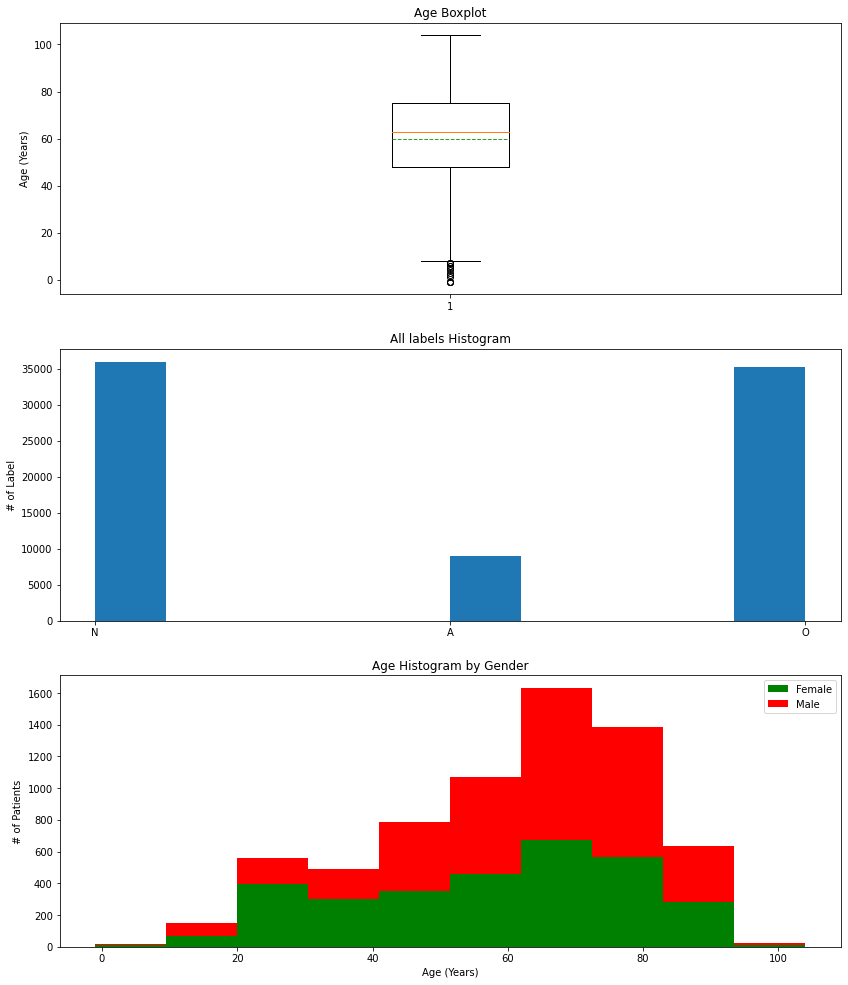

In [26]:
#only use AF and NSR
sick_ind_chinese = [i for i,l in enumerate(chinese_labels) if l=='AF']
healthy_ind_chinese = [i for i,l in enumerate(chinese_labels) if l=='NSR']
sick_ind_cardisio = [i for i,l in enumerate(cardisio_labels) if l=='AF']
healthy_ind_cardisio = [i for i,l in enumerate(cardisio_labels) if l=='NSR']



# check if array contains NaNs 
ind_age = [i for i,a in enumerate(age) if not np.isnan(a)]
ind_sex = [i for i,s in enumerate(sex)  if not s=='[nan]']
ind_age = np.array(ind_age)
ind_sex = np.array(ind_sex)
# find common indice in age and sex
ind_sex_age = (set(ind_age)).union(set(ind_sex))
ind_sex_age = np.array(ind_sex_age)

#check sex for male and female
female_ind = [i for i,s in enumerate(sex) if s=='Female']
male_ind = [i for i,s in enumerate(sex) if s=='Male']

#todo: labels into healthy and sick and check for correlations with pps




plt.figure(figsize=[14,17])
plt.subplot(311)
plt.boxplot(age[ind_age], showmeans = True, meanline = True)
plt.title('Age Boxplot')
plt.ylabel('Age (Years)')

plt.subplot(312)
plt.hist(train.label)
plt.title('All labels Histogram')
plt.ylabel('# of Label')



plt.subplot(313)
plt.hist(x = [ [age[i] for i in female_ind], [age[i] for i in male_ind] ], 
         stacked=True, color = ['g','r'],label = ['Female','Male'])
plt.title('Age Histogram by Gender')
plt.xlabel('Age (Years)')
plt.ylabel('# of Patients')
plt.legend()


Let's now check the data for NaNs and outliers..

Let's check the data for distributions and correlations of the data. The imported feature matrix is a scatter transform of the classes AF and NSR of the chinese data.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


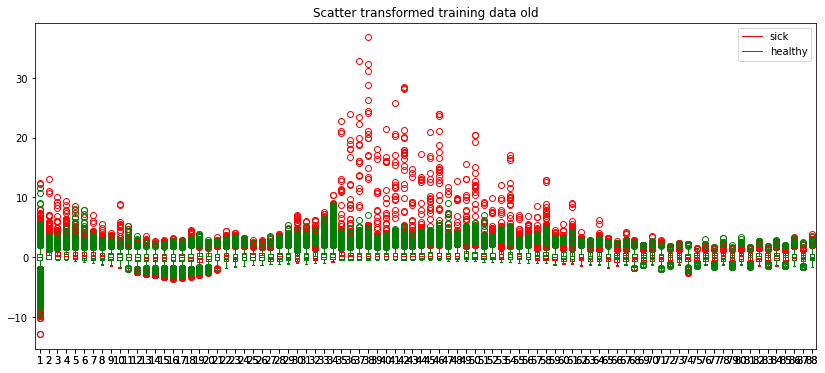

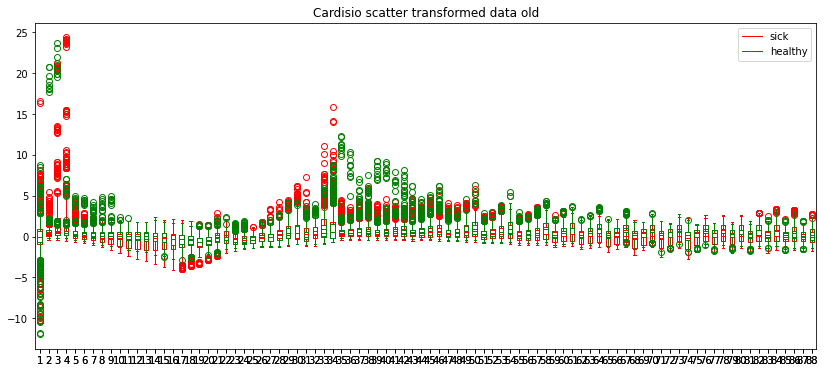

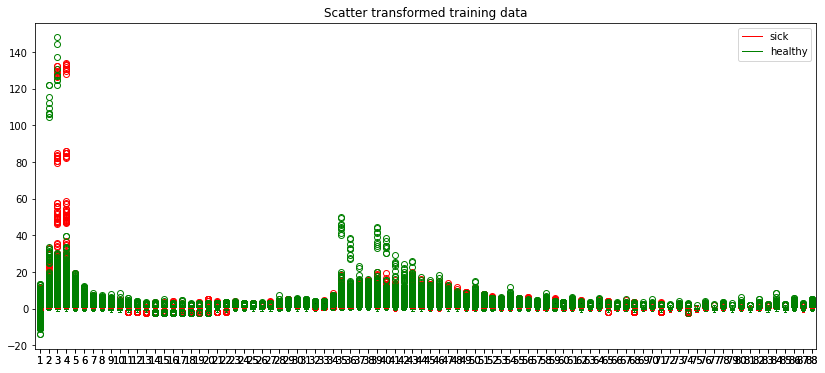

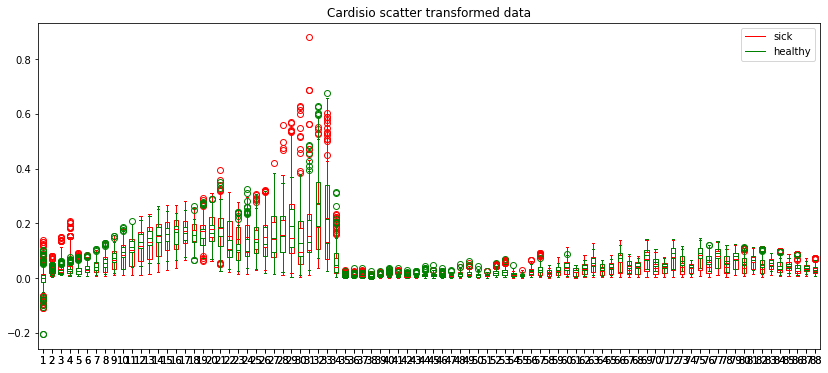

In [30]:
#data old
scaler_old = scale(chinese_measurements,1)
train_features_old = scaler_old.transform(chinese_measurements)
cardisio_features_old = scaler_old.transform(cardisio_measurements)

#train plot
custom_boxplot(train_features_old[sick_ind_chinese,:], train_features_old[healthy_ind_chinese,:], "Scatter transformed training data old")
#test plot
custom_boxplot(cardisio_features_old[sick_ind_cardisio,:], cardisio_features_old[healthy_ind_cardisio,:], "Cardisio scatter transformed data old")





#data new
scaler = scale(train_features,1)
train_features = scaler.transform(train_features)
cardisio_features = scaler.transform(test_features)

#train plot
custom_boxplot(train_features[train_svm.label=='A']  , train_features[train_svm.label=='N'] , "Scatter transformed training data")
#test plot
custom_boxplot(cardisio_features[test.label=='A'], cardisio_features[test.label=='N'], "Cardisio scatter transformed data")


The two plots show the features that were created by the scatter transform. The scatter transform can be seen as a robust presentation of the signal, that's invariant for translation and rotation. It gets trained in an unsupervised way. 
The transformation is trained with the two classes NSR and AF. 
Problematic is, that the representation of the sick class seems to be unbound and a lot of features of the sick class appear to be outliers. Furthermore the sick representation does not seem to match between the Cardisio and the Chinese data. 
My suggestion is to use all the classes of the Chinese data to train the scatter transform. More data generally has a leads to better unsupervised representation. 

Let's see if a pretraining with more data and more classes can lead to a more robust representation. (new feature matrices from 28th of September)

In [53]:
#svm with soft margin old
#C??
model_old = SVC(kernel='rbf', C=1)
X_train_old = train_features_old
[n_pat, n_feat] = np.shape(X_train_old)
y_train_old = np.zeros(n_pat)
y_train_old[sick_ind_chinese] = 1
sm = SMOTE()
X_res_old, y_res_old = sm.fit_resample(X_train_old, y_train_old)

X_test_old = cardisio_features_old
[n_pat_test, n_feat_test] = np.shape(X_test_old)
temp = np.zeros(n_pat_test)
y_test_old = temp[sick_ind_cardisio] = 1
model_old.fit(X_res_old, y_res_old)

SVC(C=1)

In [54]:
#scores = cross_val_score(clf, train_features, train_labels, cv=10)
y_pred_old = model_old.predict(X_test_old)

plot_confusion_matrix(model_old, X_test_old, y_test_old, cmap='GnBu')
plot_confusion_matrix(model_old, X_test_old, y_test_old, cmap='GnBu',normalize= 'true')
plt.show()


y_score_old = model_old.decision_function(X_test_old)
fpr, tpr, _ = roc_curve(y_test_old, y_score_old, pos_label=model_old.classes_[1])
roc_display_old = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


TypeError: ignored

In [ ]:
#svm with soft margin
#C??
model = SVC(kernel='rbf', C=0.1)
X_train = train_features
y_train = np.ravel(np.transpose(np.array([train_svm.label=='A']).astype(int)))
sm = SMOTE()
X_res, y_res = sm.fit_resample(X_train, y_train)

X_test = cardisio_features
y_test = np.ravel(np.transpose(np.array([test.label=='A']).astype(int)))
model.fit(X_res, y_res)




In [ ]:
#scores = cross_val_score(clf, train_features, train_labels, cv=10)
y_pred = model.predict(X_test)

plot_confusion_matrix(model, X_test, y_test, cmap='GnBu')
plot_confusion_matrix(model, X_test, y_test, cmap='GnBu',normalize= 'true')
plt.show()


y_score = model.decision_function(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=model.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

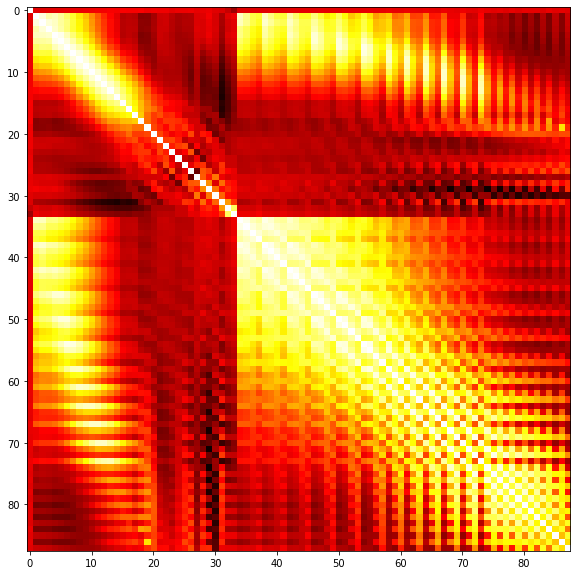

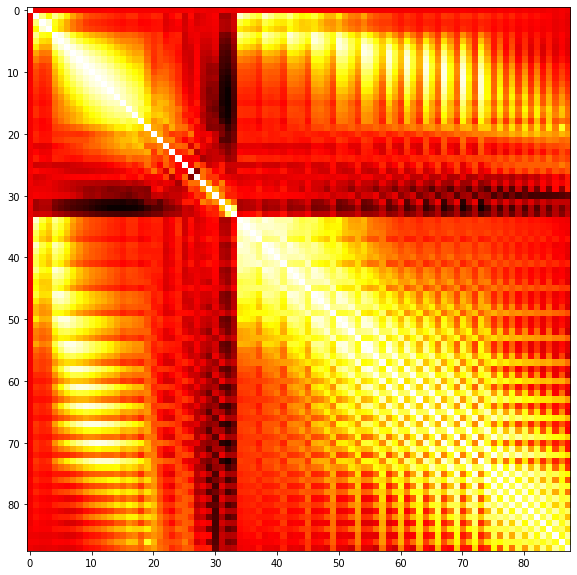

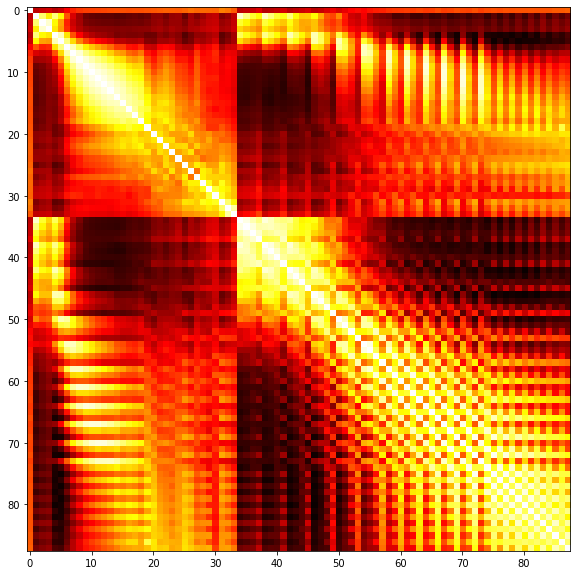

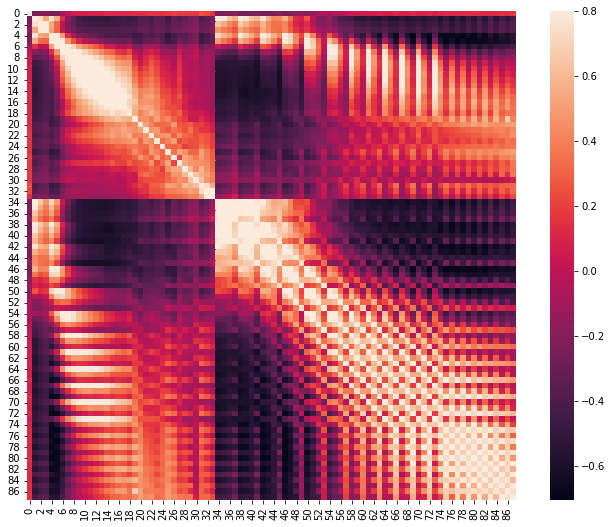

In [57]:
#smote oversampling 
import seaborn as sns

#get correlations of each features in dataset
corrmat = np.corrcoef(np.transpose(X_train_old))
fig = plt.figure(figsize=(10,10))
#plot heat map
img = plt.imshow(corrmat, cmap='hot')
plt.show()
#plt.colorbar(fig)

#get correlations of each features in dataset
corrmat = np.corrcoef(np.transpose(X_train))
fig = plt.figure(figsize=(10,10))
#plot heat map
img = plt.imshow(corrmat, cmap='hot')
plt.show()
#plt.colorbar(fig)





#dim reduction? check for correlations and also feature selection 
from sklearn import decomposition
pca = decomposition.PCA()
pca.fit(np.transpose(X_train))
X_train_pca = pca.transform(np.transpose(X_train))

corrmat = np.corrcoef((X_train_pca))
plt.figure(figsize=(10,10))
#plot heat map
plt.imshow(corrmat, cmap='hot')
plt.show()



#correlation matrix
corrmat = np.corrcoef((X_train_pca))
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [ ]:
#pair plots of entire dataset
pp = sns.pairplot(data1, hue = 'Survived', palette = 'deep', size=1.2, diag_kind = 'kde', diag_kws=dict(shade=True), plot_kws=dict(s=10) )
pp.set(xticklabels=[])